### __Imports__

In [1]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [61]:
from icnnet import ICNNet
from mydataset import MyDataset, get_gaussian_dataset, get_gaussian_transport_dataset
from toy_data_dataloader_gaussian import generate_gaussian_dataset, get_dataset
from train_picnn import PICNNtrain
from train_makkuva import train_makkuva, train_makkuva_epoch

In [3]:
%load_ext autoreload
%autoreload 2

## __Generate dataset__


In [98]:
dataset = get_dataset(d=2, r=200, N=500) #valou
dataset = generate_gaussian_dataset(d=2, r=200, N=200) #thomas
gaussian_dataset = get_gaussian_dataset(dataset)
gaussian_transport_dataset = get_gaussian_transport_dataset(gaussian_dataset)


/users/eleves-b/2021/valentin.dorseuil/Desktop/CondOT/gaussian_transport.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u)


## __Initialization__

### __PICNN training__

In [99]:
input_size = 2
output_size = 1
context_layer_sizes = [input_size, 64, 64, 64,output_size]
layer_sizes = [input_size, 64, 64, 64,output_size]

model_init_f = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes, init_bunne = True)
model_init_g = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes, init_bunne = True)

In [100]:
print('training f')
gaussian_transport_dataloader = DataLoader(gaussian_transport_dataset, batch_size=50, shuffle=True)
PICNNtrain(model_init_f, gaussian_transport_dataloader, epochs=100)

print('training g')
reversed_gaussian_dataset = MyDataset(gaussian_dataset.Y, gaussian_dataset.C, gaussian_dataset.X)
gaussian_transport_dataset_reversed = get_gaussian_transport_dataset(reversed_gaussian_dataset)
gaussian_transport_dataloader_reversed = DataLoader(gaussian_transport_dataset_reversed, batch_size=50, shuffle=True)
PICNNtrain(model_init_g, gaussian_transport_dataloader_reversed, epochs=100)

training f
Epoch 1/100 Loss: 29.360393524169922
Epoch 2/100 Loss: 21.40982437133789


/users/eleves-b/2021/valentin.dorseuil/Desktop/CondOT/condot/lib64/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50, 200, 2])) that is different to the input size (torch.Size([50, 200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/100 Loss: 11.230827331542969
Epoch 4/100 Loss: 10.441689491271973
Epoch 5/100 Loss: 9.042147636413574
Epoch 6/100 Loss: 7.350844383239746
Epoch 7/100 Loss: 6.251904487609863
Epoch 8/100 Loss: 6.436502933502197
Epoch 9/100 Loss: 6.589376449584961
Epoch 10/100 Loss: 5.869926929473877
Epoch 11/100 Loss: 5.521676063537598
Epoch 12/100 Loss: 5.363464832305908
Epoch 13/100 Loss: 5.88376522064209
Epoch 14/100 Loss: 5.0753045082092285
Epoch 15/100 Loss: 5.496426582336426
Epoch 16/100 Loss: 5.156809329986572
Epoch 17/100 Loss: 4.8999152183532715
Epoch 18/100 Loss: 4.970643520355225
Epoch 19/100 Loss: 4.9347381591796875
Epoch 20/100 Loss: 4.856418609619141
Epoch 21/100 Loss: 4.38258695602417
Epoch 22/100 Loss: 4.506058216094971
Epoch 23/100 Loss: 5.073164939880371
Epoch 24/100 Loss: 5.12883996963501
Epoch 25/100 Loss: 4.4201273918151855
Epoch 26/100 Loss: 4.76342248916626
Epoch 27/100 Loss: 4.368617057800293
Epoch 28/100 Loss: 4.430703163146973
Epoch 29/100 Loss: 4.342726230621338
Epoch 

In [101]:
state_dict_init_f = model_init_f.state_dict()
state_dict_init_g = model_init_g.state_dict()

In [102]:
test = 8
n_points = 200
X, Y, C = gaussian_dataset.X, gaussian_dataset.Y, gaussian_dataset.C

x_i, y_i, c_i = X[test, :n_points, :].requires_grad_(True), Y[test, :n_points, :].requires_grad_(True), C[test, :n_points, :]

#Calcul de la dérivée du PICNN
output_model_f = model_init_f(x_i, c_i)
grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model_f), create_graph=True)[0].detach().numpy()

output_model_g = model_init_g(y_i, c_i)
grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model_g), create_graph=True)[0].detach().numpy()

x_i, y_i = x_i.detach().numpy(), y_i.detach().numpy()

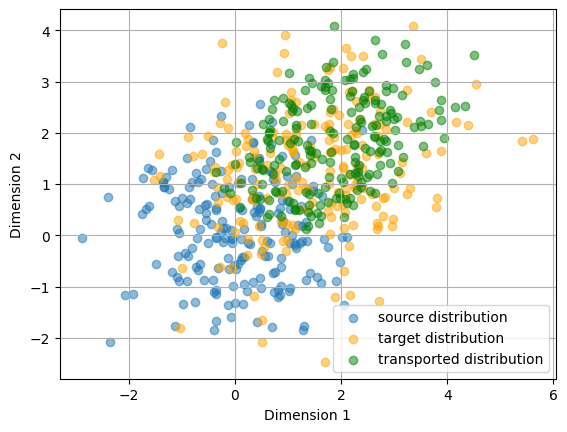

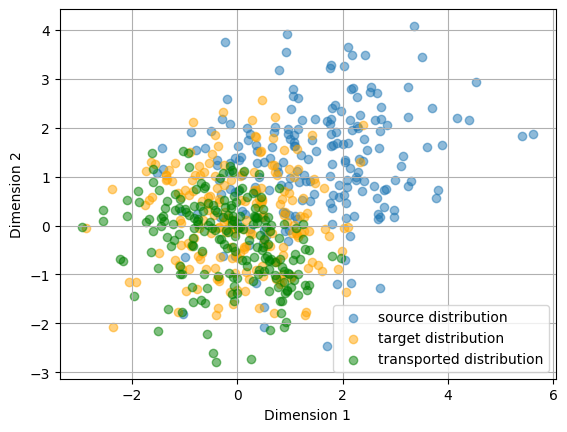

In [89]:
def plot_transport(source_distribution, target_distribution, transported_distribution):
    plt.scatter(source_distribution[:, 0], source_distribution[:, 1], alpha=0.5, label='source distribution')
    plt.scatter(target_distribution[:, 0], target_distribution[:, 1], color='orange', alpha=0.5, label='target distribution')
    plt.scatter(transported_distribution[:, 0], transported_distribution[:, 1], alpha=0.5, color='green', label='transported distribution')

    for i in range(x_i.shape[0]):
        t=1
        #plt.arrow(source_distribution[i, 0], source_distribution[i, 1], transported_distribution[i, 0] - source_distribution[i, 0], transported_distribution[i, 1] - source_distribution[i, 1], color='green', alpha=0.25, head_width=0.1, head_length=0.1, length_includes_head=True)
        #plt.arrow(transported_distribution[i, 0], transported_distribution[i, 1], target_distribution[i, 0] - transported_distribution[i, 0], target_distribution[i, 1] - transported_distribution[i, 1], color='orange', alpha=0.25, head_width=0.1, head_length=0.1, length_includes_head=True)

        
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_transport(source_distribution=x_i, target_distribution=y_i, transported_distribution=grad_model_f)
plot_transport(source_distribution=y_i, target_distribution=x_i, transported_distribution=grad_model_g)

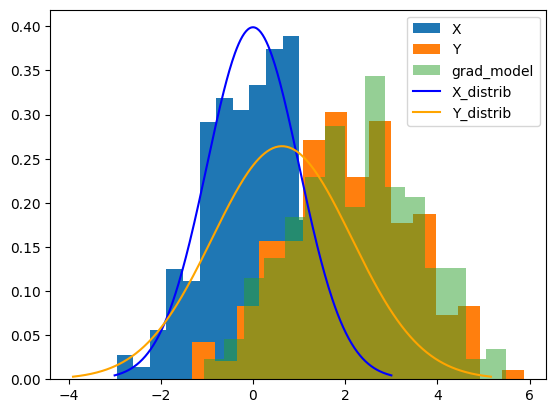

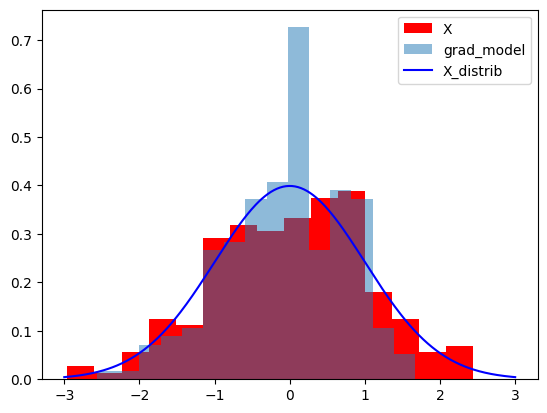

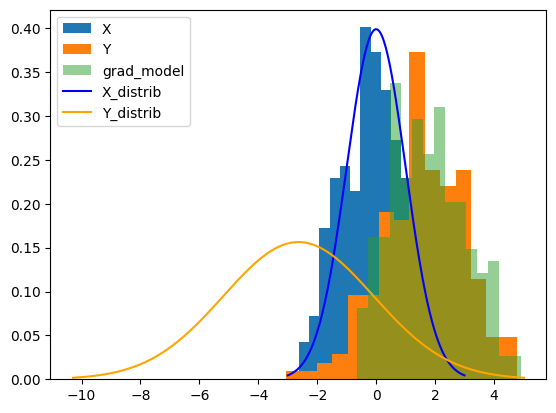

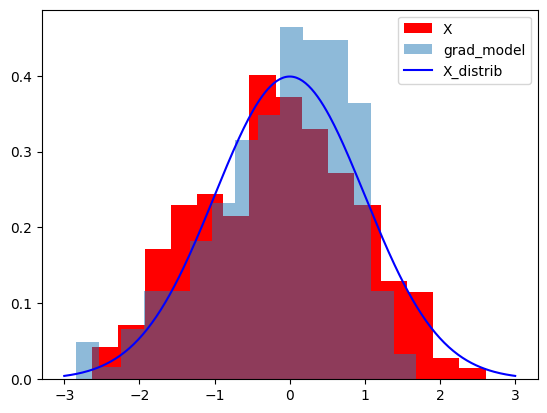

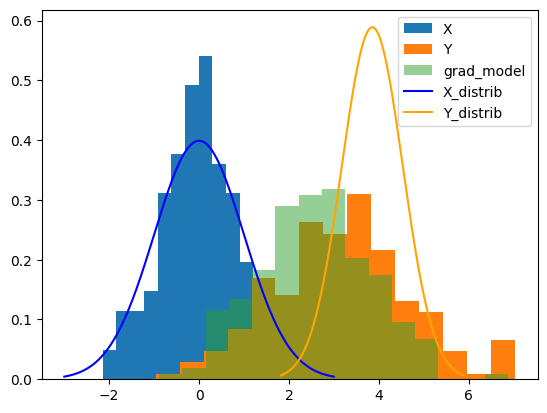

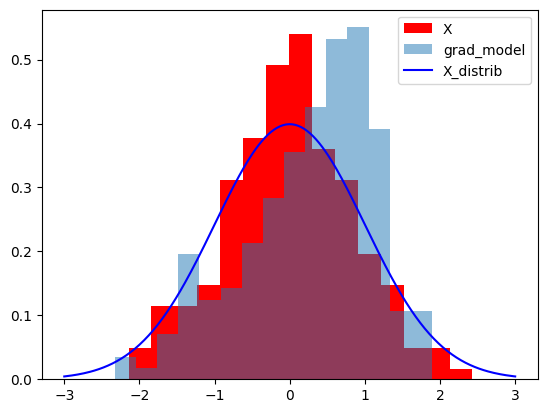

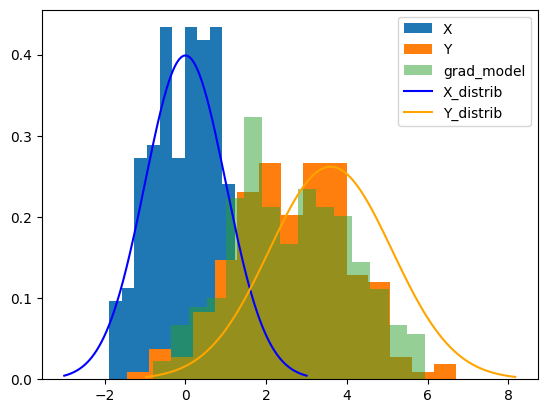

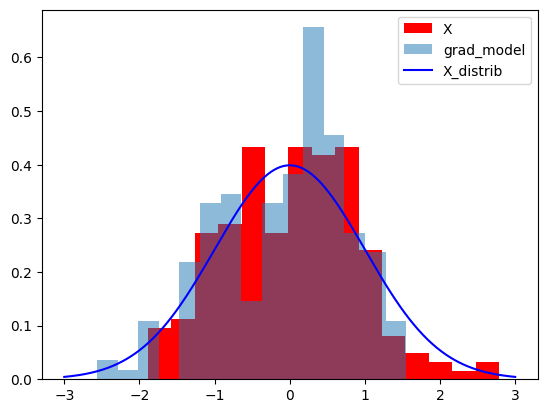

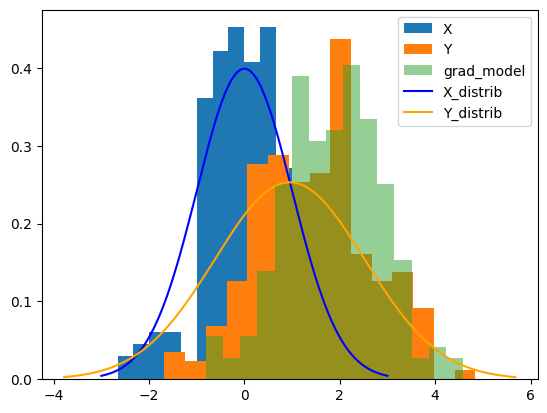

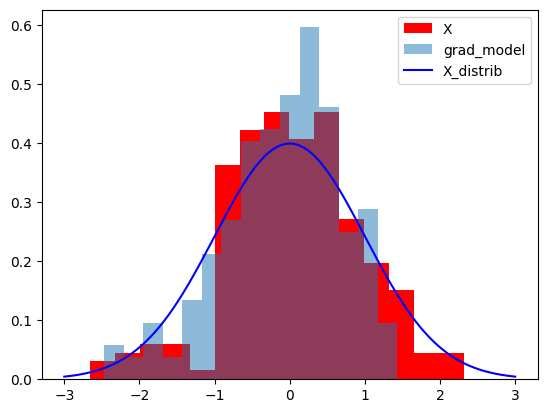

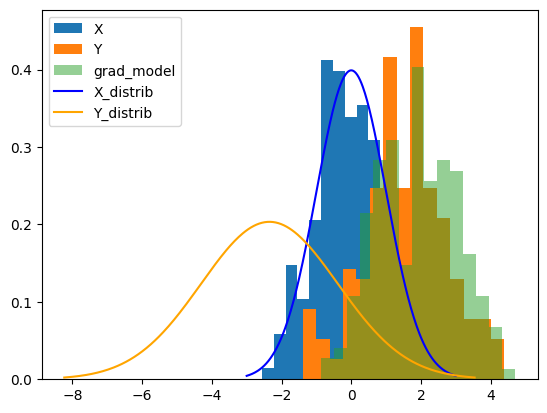

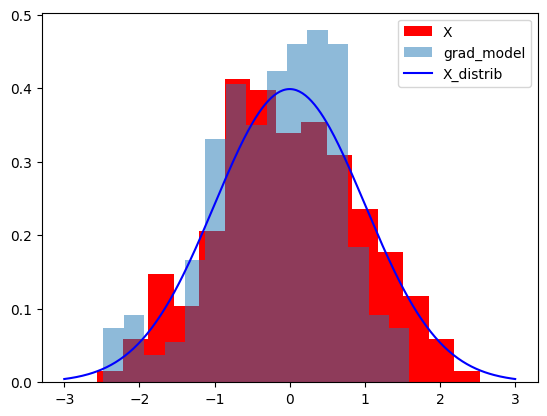

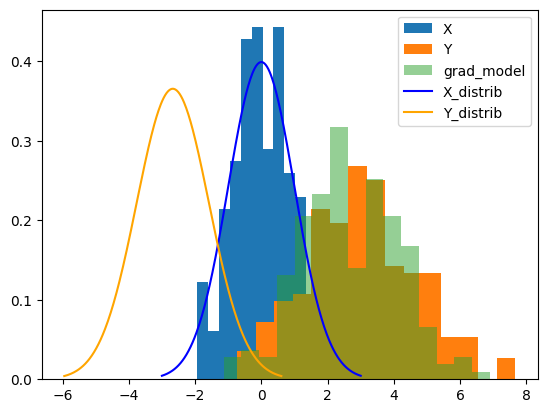

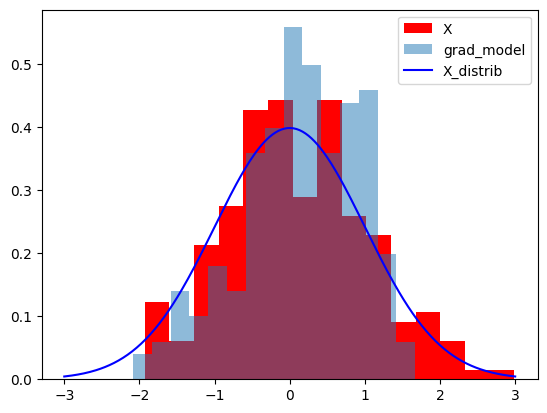

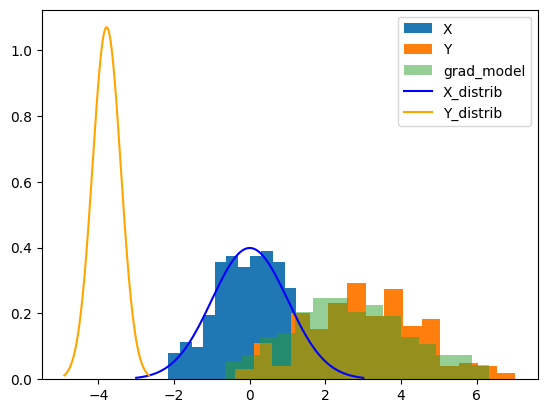

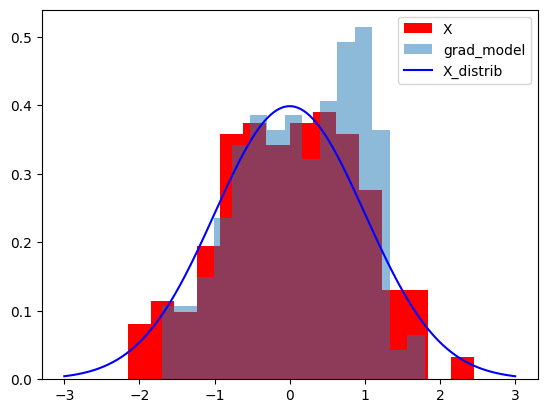

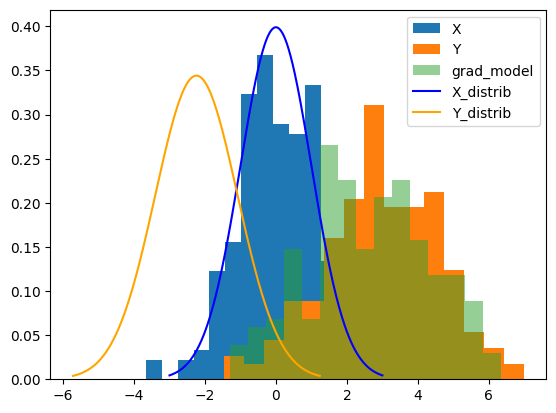

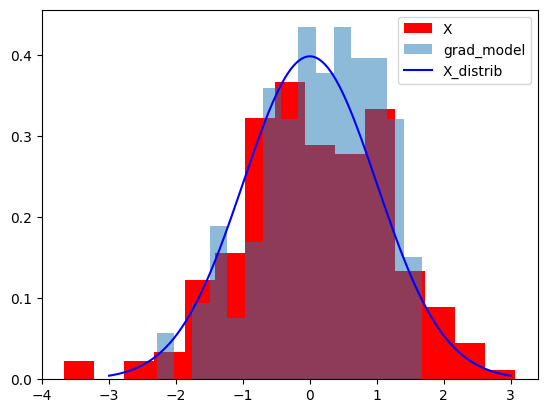

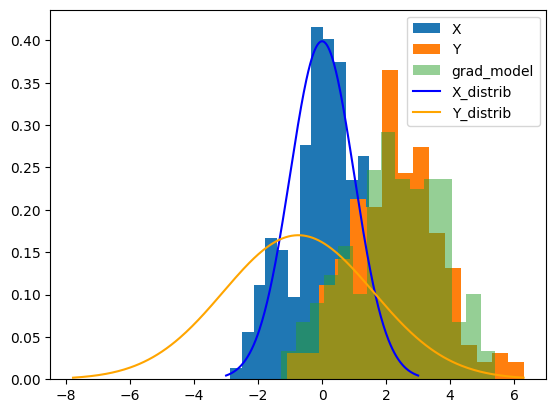

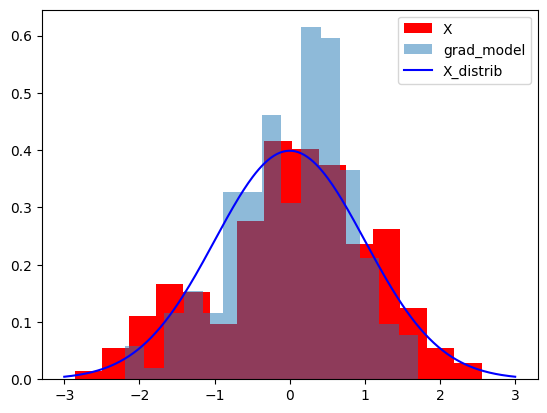

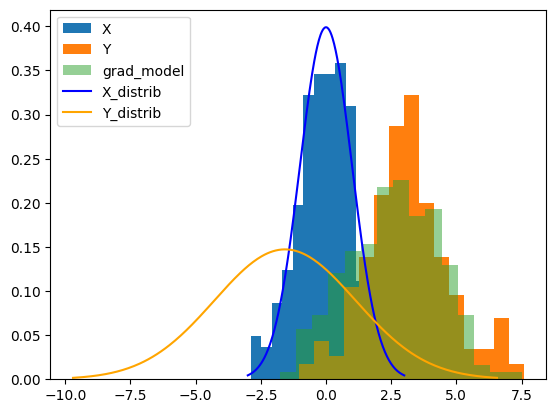

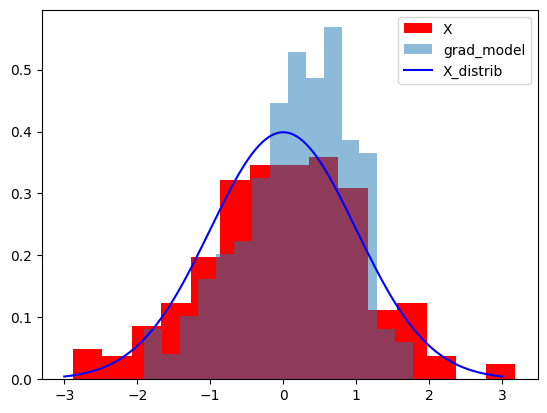

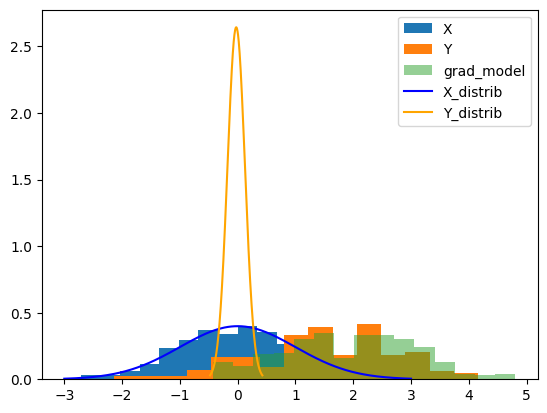

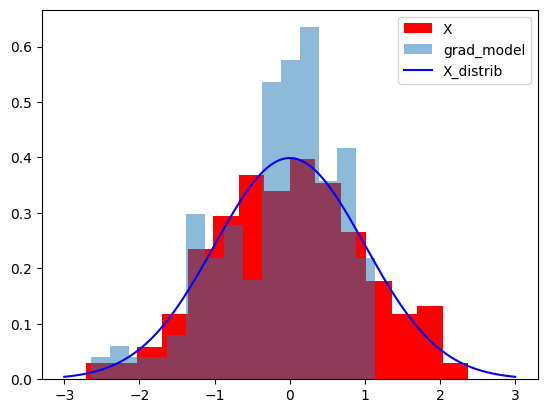

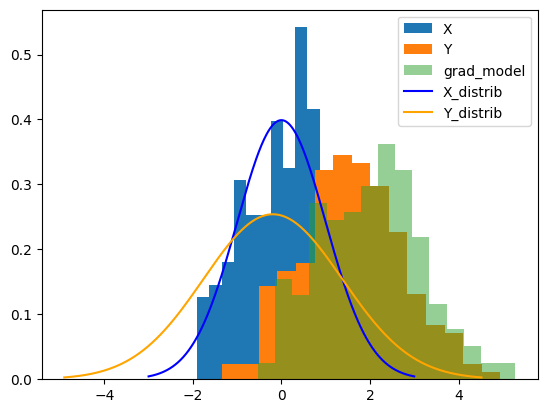

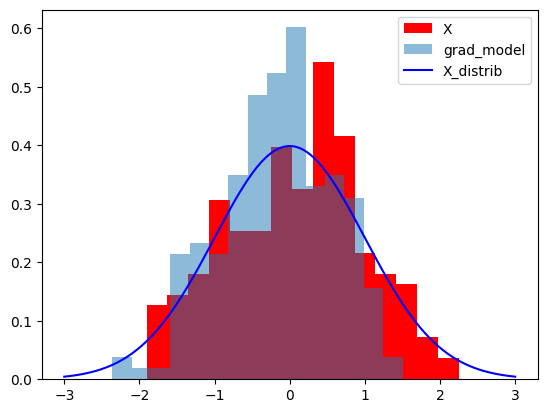

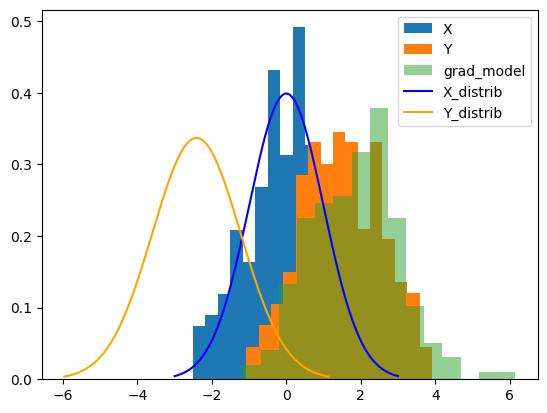

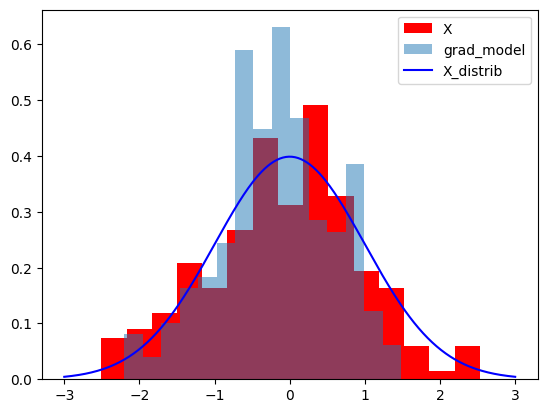

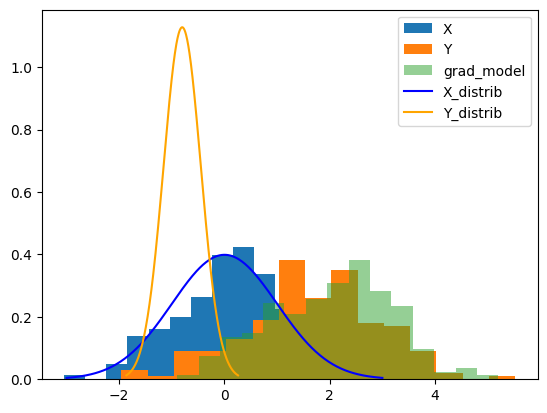

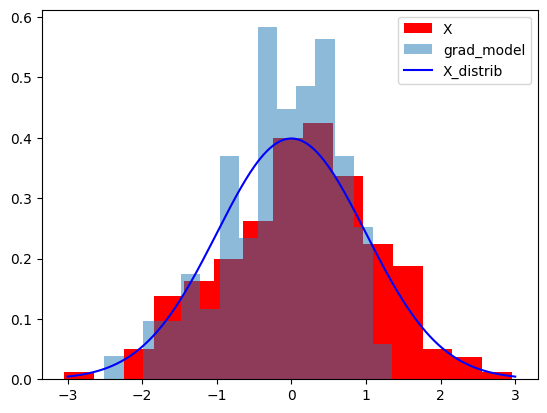

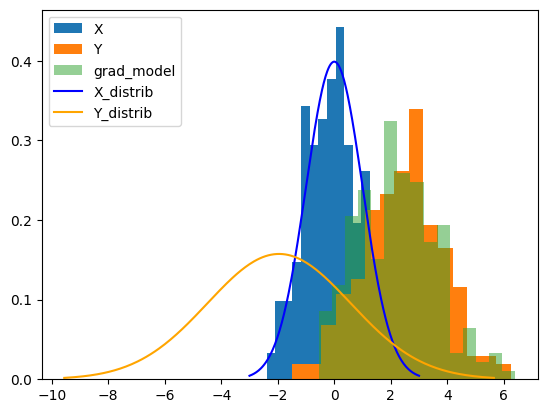

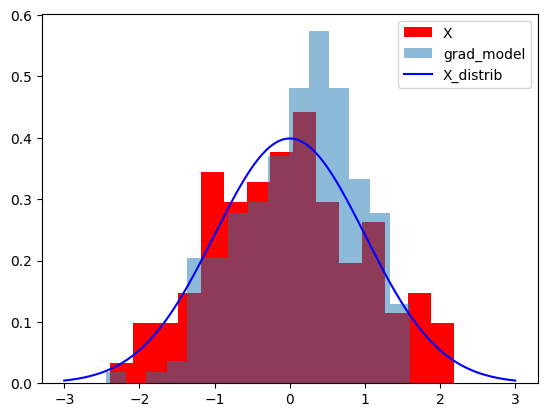

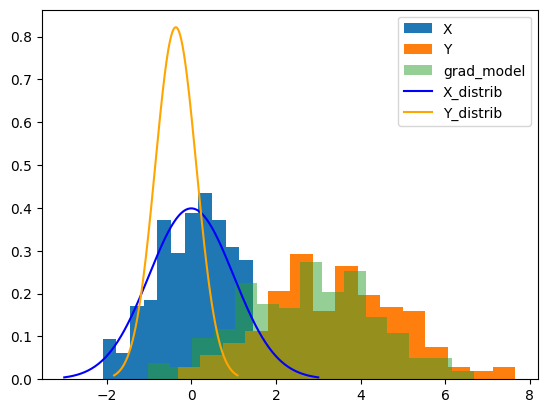

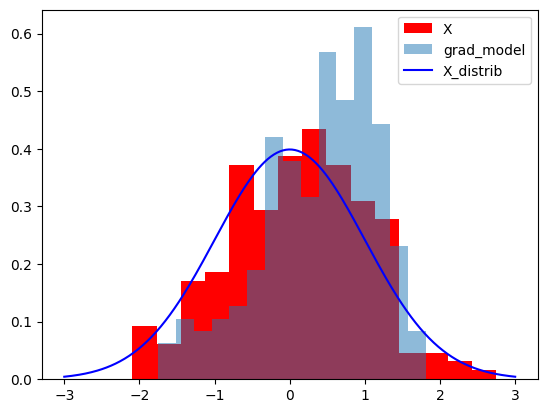

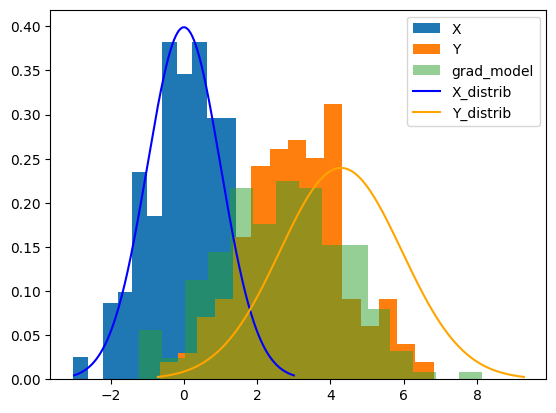

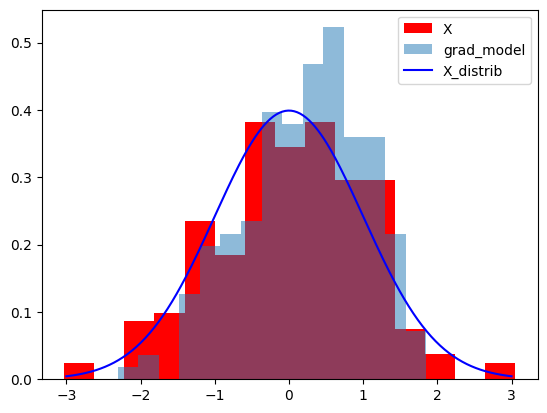

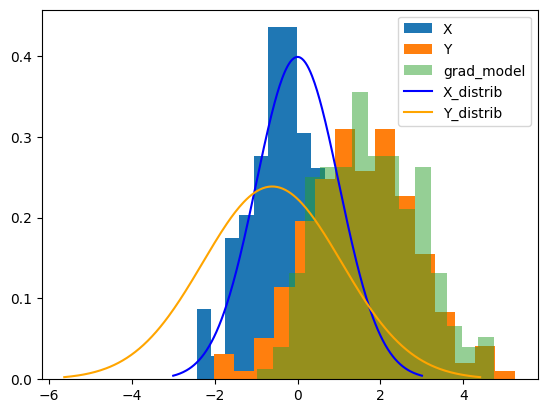

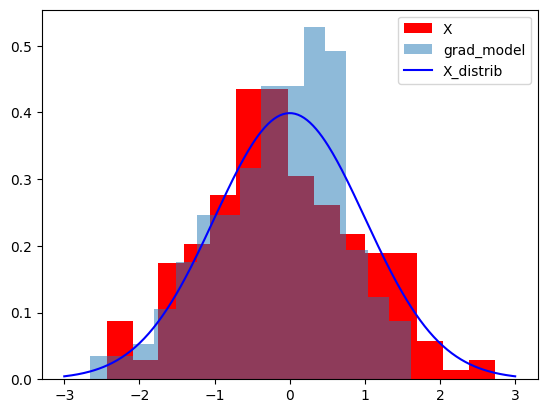

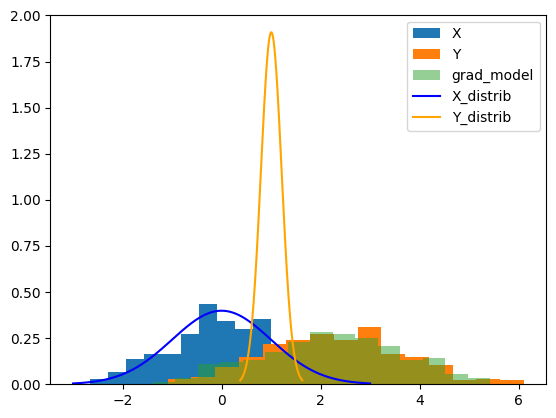

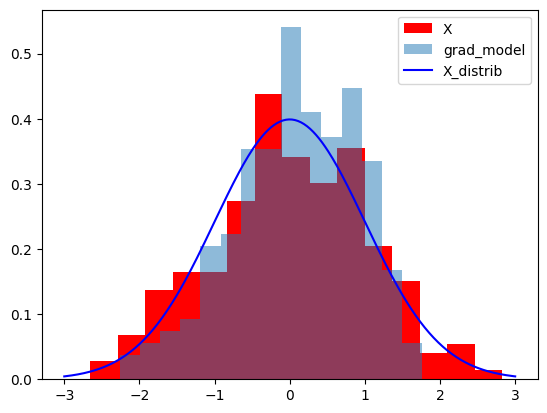

In [103]:
X, Y, C = gaussian_dataset.X, gaussian_dataset.Y, gaussian_dataset.C
#Calcul de la dérivée du PICNN

for test in range(20):
    x_i = X[test, :, :]
    y_i = Y[test, :, :]
    c_i = C[test, :, :]

    locs = c_i[:,0]
    #print(locs)

    scales = c_i[:,1]
    #print(scales)  


    y_i.requires_grad_(True)
    x_i.requires_grad_(True)
    #c_i.requires_grad_(True)    

    output_model_f = model_init_f(x_i, c_i)
    grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model_f), create_graph=True)[0].detach().numpy()

    plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
    plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
    plt.hist(grad_model_f[:, 0],  bins=15, label = 'grad_model', density = True, alpha = 0.5)
    # plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
    interval_x = np.linspace(-3, 3, 300)
    interval_y = np.linspace(-3*scales[0] + locs[0], 3*scales[0] + locs[0], 300)

    plt.plot(interval_x, stats.norm.pdf(interval_x, loc=0, scale=1), label = 'X_distrib', color = 'blue')
    plt.plot(interval_y, stats.norm.pdf(interval_y, loc = locs[0], scale = scales[0]), label = 'Y_distrib', color = 'orange')

    plt.legend()
    plt.show()


    output_model_g = model_init_g(y_i, c_i)
    grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model_g), create_graph=True)[0].detach().numpy()
    plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True, color = 'red')
    #plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True, color = 'blue')
    plt.hist(grad_model_g[:, 0],  bins=15, label = 'grad_model', density = True, alpha = 0.5)
    # plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)
    interval_x = np.linspace(-3, 3, 300)
    interval_y = np.linspace(-3*scales[0] + locs[0], 3*scales[0] + locs[0], 300)

    plt.plot(interval_x, stats.norm.pdf(interval_x, loc=0, scale=1), label = 'X_distrib', color = 'blue')
    #plt.plot(interval_y, stats.norm.pdf(interval_y, loc = locs[0], scale = scales[0]), label = 'Y_distrib', color = 'orange')

    plt.legend()
    plt.show()

## __Makkuva__

In [104]:
ICNNf = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)
ICNNg = ICNNet(input_size = input_size, layer_sizes = layer_sizes, context_layer_sizes=context_layer_sizes)

# Load the state dictionary into ICNNf and ICNNg
ICNNf.load_state_dict(state_dict_init_f)
ICNNg.load_state_dict(state_dict_init_g)

<All keys matched successfully>

In [105]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

for epoch in range(50) :
    print('epoch :', epoch + 1, end=('\r'))
    train_makkuva_epoch(ICNNf, ICNNg, dataloader)

loss_g: 1.5066156387329102, loss_f: -4.565278649330139
loss_g: 3.3864047527313232, loss_f: 2.8683167099952698
loss_g: -0.1797509789466858, loss_f: -15.9438955783844
loss_g: 3.6825170516967773, loss_f: 2.5981253385543823
loss_g: -5.706599712371826, loss_f: -65.94027042388916
loss_g: 3.5104336738586426, loss_f: 1.1203468441963196
loss_g: 0.7608650326728821, loss_f: -16.768609046936035
loss_g: 3.829639196395874, loss_f: 2.8629709482192993
loss_g: 0.3293802738189697, loss_f: -25.72008752822876
loss_g: 4.18267822265625, loss_f: 2.6788067519664764
loss_g: -2.080822229385376, loss_f: -53.20494365692139
loss_g: 4.186039924621582, loss_f: 2.1216788589954376
loss_g: 0.2139536291360855, loss_f: -31.34725522994995


KeyboardInterrupt: 

In [93]:
# filename_pth_f = 'ICNNf_TR.pth'
# filename_pth_g = 'ICNNg_TR.pth'

# torch.save(ICNNf.state_dict(), filename_pth_f)
# torch.save(ICNNg.state_dict(), filename_pth_g)

In [96]:
test = 5
n_points = 200
X, Y, C = dataset.X, dataset.Y, dataset.C
x_i, y_i, c_i = X[test, :n_points, :].requires_grad_(True), Y[test, :n_points, :].requires_grad_(True), C[test, :n_points, :]

#Calcul de la dérivée du PICNN
output_model_f = ICNNf(x_i, c_i)
grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model_f), create_graph=True)[0].detach().numpy()

output_model_g = model_init_g(y_i, c_i)
grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model_g), create_graph=True)[0].detach().numpy()

x_i, y_i = x_i.detach().numpy(), y_i.detach().numpy()

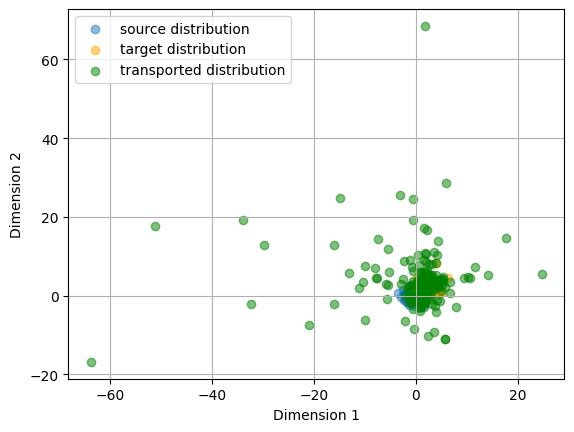

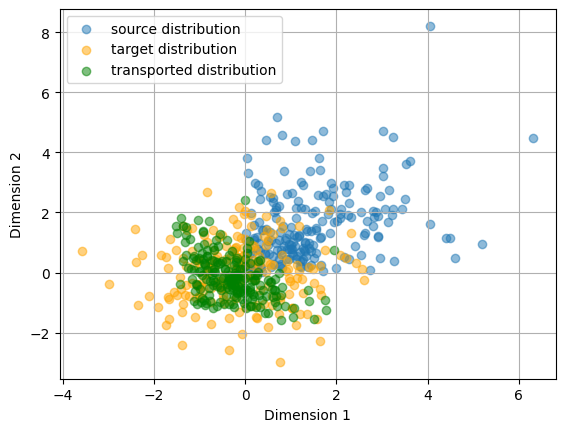

In [97]:
plot_transport(source_distribution=x_i, target_distribution=y_i, transported_distribution=grad_model_f)
plot_transport(source_distribution=y_i, target_distribution=x_i, transported_distribution=grad_model_g)